# Two-Tier Urban Deliveries with Robots with no time windows

## MIP model
##### Decision variables:

| Variable |    |
|------|------|
|   $x_{c}^{wrd} = 1$| if robot $r=1, ..., r_{max}$ from hub $d$ serves customer $c$, where $d=1, ..., n; c\in C_{d}^{\omega}; \omega \in \Omega$|
|$x_{c}^{wrd} = 0$|otherwise|
|$o^{d}=1$|if hub $d$ is opened where $d=1,...,n$|
|$o^{d}=0$:|otherwise|

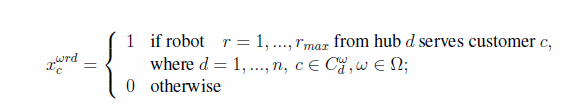

##### Objective Function
$$ min \sum_{d=1}^n o^{d}
$$


##### Constraints:
1.

| No. | Constraint   |
|------|------|
|   1  | table|

## Gurobi Model

In [7]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter  # for some testing [optional]
import ipywidgets as widgets  # for interactive plots [optional]
from ipywidgets import interact, interact_manual  # for interactive plots [optional]

#### Some custom functions for later use

In [8]:
def grid (a, n=None, spacing=None):
    """
    distribute n points evenly in a 2-dimensional square of side length a
    or create a square grid with suqare cells of length c
    """
    if spacing is None:
        assert n
        spacing = a // int(np.sqrt(n))
        base = range(spacing//2, a, spacing)
    if n is None:
        assert spacing
        base = range(0, a+1, spacing)
    return[(x,y) for x in base for y in base]

def travel_time(first: tuple, second:tuple, speed):
    """
    compute the travel time between first and second
    first, second: given as (x, y) tuples 
    speed: given in km/h
    """
    dist = abs(first[0] - second[0]) + abs(first[1] - second[1])  # Manhattan distance in m (!) because input is in meters
    return (dist/1000)/speed  # travel time in hours



#### Model inputs

In [9]:
np.random.seed(0)  # for reproducable results

n = 100  # number of clients
h = 16  # number of potential hubs (should be a square number (4, 9, 16, 25, ...) for an even distribution)
r_max = 5  # number of robots per hub
num_instances = 10

# downtown
area= 2000  # 2km * 2km square
block = 100  # 100m * 100m blocks

M = 6  # maximum allowed driving time per robot (hrs)
tf = 45/60  # robots' full recharge time (hrs)
b = 2  # robots' battery range (hrs)
ts = 4/60  # customer service time (hrs)
v = 3  # robot speed (km/h)

H = [i for i in range(h)]  # hubs
R = [i for i in range(r_max)]  # robots
N = [i for i in range(n)]  # customers
I = [i for i in range(num_instances)]  # instances

hub_coords = grid(a=area, n=h)

grid_x, grid_y = zip(*grid(a=area, spacing=block))
customer_coords = gp.tupledict()
for instance in I:  # originally, smaller instances are subsets of the bigger ones (n=300), here all instances are unique atm
    for customer in N:
        customer_coords[instance, customer] = (np.random.choice(grid_x), np.random.choice(grid_y))


t = gp.tupledict()  # pendulum distances
for hub in H:
    for instance in I:
        for customer in N:
            t[hub, instance, customer] = 2*travel_time(first=hub_coords[hub],
                                                     second=customer_coords[instance, customer],
                                                     speed=v)
            
reachables = [key for (key, value) in t.items() if value <=b]  # customers within battery range of each hub

#### Plotting hubs and a single instance

In [21]:
colors = plt.get_cmap('hsv', h)
hubs_x, hubs_y = zip(*hub_coords)

def base_plot(plot_instance:int):
    plt.scatter(hubs_x, hubs_y, cmap=colors, c=H, marker='s', s=75, edgecolors='black')
    customers_x, customers_y = zip(*customer_coords.select(plot_instance, '*'))
    plt.scatter(customers_x, customers_y, c='black', alpha=0.3)
    for customer in N:
        plt.annotate(s=customer, xy=(customers_x[customer], customers_y[customer]))
    plt.xlim(0, area)
    plt.ylim(0, area)
    plt.grid()
interact(base_plot, plot_instance=I);

interactive(children=(Dropdown(description='plot_instance', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), …

### Tier 1: Minimize the number of hubs

#### Model, decision variables and objective function

In [12]:
model1 = gp.Model('min_hubs')

# add hub-robot-instance-customer binary decision variables
x1 = model1.addVars(reachables, R, vtype=GRB.BINARY, name='x')
# format of x1 vars: (hub, instance, customer, robot)

# add is-hub-open binary decision variables
o1 = model1.addVars(H, vtype=GRB.BINARY, name='o')

model1.setObjective(gp.quicksum(o1), sense=GRB.MINIMIZE)
model1.update()

Using license file C:\Users\steff\gurobi.lic
Academic license - for non-commercial use only


#### Adding constraints

In [13]:
# All instance-customer locations must be assigned to exactly one hub-robot combination
for instance in I:
    for customer in N:
        model1.addConstr(x1.sum('*', instance, customer, '*') == 1)

In [14]:
# limit on the maximum robot working time. First create a dictionary with the respective coefficients then add linear expression
coeff1 = gp.tupledict({
    (hub, instance, customer, robot): t[hub, instance, customer] * (1 + (tf / b)) + ts
    for hub in H
    for instance in I
    for customer in N
    for robot in R
})

for hub in H:
    for robot in R:
        for instance in I:
            model1.addConstr(x1.prod(coeff1, hub, instance, '*', robot) <= M)

In [15]:
# if a robot serves a customer location (in some instance), the corresponding robot hub is open
for hub in H:
    for instance in I:
        for customer in N:
            model1.addConstr(x1.sum(hub, instance, customer, '*') <= o1.select(hub)[0])

#### Solve Model 1

In [16]:
model1.setParam('TimeLimit', 240)  # for testing only
model1.optimize()

Changed value of parameter TimeLimit to 240.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 17800 rows, 79306 columns and 253870 nonzeros
Model fingerprint: 0x26843f4f
Variable types: 0 continuous, 79306 integer (79306 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 142 rows and 0 columns
Presolve time: 1.10s
Presolved: 17658 rows, 79306 columns, 253728 nonzeros
Variable types: 0 continuous, 79306 integer (79306 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.000000e+00, 14790 iterations, 2.95 seconds
Total elapsed time = 22.61s

    Nodes    |    Current Node    |     Objective Bounds      |    

#### Inspect and plot one of the instances with the solution

In [17]:
x1_solution = model1.getAttr('x', x1)
assignment1 = gp.tupledict({
    (key[1], key[2]):(key[0], key[3]) 
    for key, value in x1_solution.items() 
    if value > 0.5})  # (instance, customer): (hub, robot)
assignment1

{(1, 83): (1, 3),
 (1, 90): (1, 3),
 (1, 96): (1, 3),
 (1, 97): (1, 0),
 (2, 89): (1, 3),
 (2, 90): (1, 0),
 (2, 92): (1, 4),
 (2, 96): (1, 0),
 (2, 98): (1, 0),
 (5, 67): (1, 4),
 (5, 95): (1, 0),
 (8, 91): (1, 2),
 (8, 94): (1, 2),
 (8, 98): (1, 0),
 (9, 49): (1, 0),
 (9, 53): (1, 0),
 (9, 55): (1, 0),
 (9, 56): (1, 0),
 (9, 65): (1, 3),
 (9, 70): (1, 0),
 (9, 71): (1, 0),
 (9, 72): (1, 0),
 (9, 81): (1, 0),
 (9, 82): (1, 0),
 (9, 84): (1, 0),
 (9, 90): (1, 0),
 (0, 1): (5, 0),
 (0, 2): (5, 4),
 (0, 3): (5, 4),
 (0, 4): (5, 4),
 (0, 5): (5, 2),
 (0, 6): (5, 0),
 (0, 7): (5, 3),
 (0, 8): (5, 1),
 (0, 9): (5, 3),
 (0, 10): (5, 4),
 (0, 11): (5, 1),
 (0, 12): (5, 1),
 (0, 13): (5, 0),
 (0, 14): (5, 1),
 (0, 15): (5, 1),
 (0, 16): (5, 3),
 (0, 17): (5, 0),
 (0, 18): (5, 2),
 (0, 19): (5, 4),
 (0, 20): (5, 2),
 (0, 21): (5, 3),
 (0, 22): (5, 2),
 (0, 23): (5, 2),
 (0, 24): (5, 1),
 (0, 25): (5, 0),
 (0, 29): (5, 3),
 (0, 32): (5, 2),
 (0, 33): (5, 0),
 (0, 51): (5, 4),
 (0, 56): (5, 2),
 

In [40]:
o1_solution = model1.getAttr('x', o1)
p = len([key for key, value in o1_solution.items() if value > 0.5])  # min number of open hubs
p

5

In [28]:
def model1_plot(plot_instance):
    colors = plt.get_cmap('hsv', p)
    hub_colors = []
    for hub in H:
        if o1_solution[hub] > 0.5:
            hub_colors.append(colors(hub/h))
        else:
            hub_colors.append('white')

    plt.scatter(hubs_x, hubs_y, c=hub_colors, marker='s', s=75, edgecolors='black')
    
    if plot_instance is not None:
        customer_colors = []
        for customer in N:
            customer_colors.append(colors(assignment1[plot_instance, customer][0]/h))  

        customers_x, customers_y = zip(*customer_coords.select(plot_instance, '*'))  
        plt.scatter(customers_x, customers_y, c=customer_colors, alpha=1, edgecolors='black')

        if n <= 100:
            for customer in N:
                plt.annotate(s=customer, xy=(customers_x[customer], customers_y[customer]))

    plt.xlim(0, area)
    plt.ylim(0, area);
    # plt.gcf().set_size_inches(20,10)
interact(model1_plot, plot_instance=[None]+I);

interactive(children=(Dropdown(description='plot_instance', options=(None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9), valu…

### Tier 2: Minimize operational robot cost

#### Model, decision variables, objective function

In [31]:
model2 = gp.Model('min_cost')

# add decision variables
x2 = model2.addVars(reachables, R, vtype=GRB.BINARY, name='x')
o2 = model2.addVars(H, vtype=GRB.BINARY, name= 'o')

# set the objective function
coeff2 = gp.tupledict({
    (hub, instance, customer, robot): t[hub, instance, customer]
    for hub in H
    for instance in I
    for customer in N
    for robot in R
})

model2.setObjective(x2.prod(coeff2), sense=GRB.MINIMIZE)
model2.update()
# model2.getObjective()

#### Add constraints

In [32]:
# define the constraints
# All customer locations must be assigned to exactly one hub-robot combination (same as in first model)
for instance in I:
    for customer in N:
        model2.addConstr(x2.sum('*', instance, customer, '*') == 1)
        
# limit the robot max working time (same as in first model)
for hub in H:
    for instance in I:
        for robot in R:
            model2.addConstr(x2.prod(coeff1, hub, instance, '*', robot) <= M)
        
# Hub is open when one customer is served by any of its robots ????? (4) in paper
for hub in H:
    for instance in I:
        for customer in N:
            model2.addConstr(x2.sum(hub, instance, customer, '*') <= o2.select(hub)[0])

# ensure that there are exactly as many open robot hubs as provided by first model
model2.addConstr(o2.sum() == p)

model2.update()

#### Solve Model 2

In [33]:
model2.optimize()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 17801 rows, 79306 columns and 253886 nonzeros
Model fingerprint: 0x4eee6869
Variable types: 0 continuous, 79306 integer (79306 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  Objective range  [7e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 142 rows and 0 columns
Presolve time: 0.99s
Presolved: 17659 rows, 79306 columns, 253744 nonzeros
Variable types: 0 continuous, 79306 integer (79306 binary)
Found heuristic solution: objective 365.8666667

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.224000e+02, 4952 iterations, 2.50 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  322.40000    0 1324  36

#### Inspect and plot solution of Model 2

In [34]:
objValue2 = model2.getObjective().getValue()
objValue2

322.86666666666497

In [35]:
x2_solution = model2.getAttr('x', x2)
# customer: (hub, robot) lookup dict
assignment2 = gp.tupledict({
    (key[1], key[2]):(key[0], key[3]) 
    for key, value in x2_solution.items() 
    if value > 0.5})
assignment2
# test whether the constraints are satisfied: every customer is assigned to one robot and one hub
Counter([x2_solution.sum('*', instance, customer, '*' ).getValue() == 1 for customer in N for instance in I])

Counter({True: 1000})

In [36]:
# test the constraints: maximum working time of robots
Counter([x2.prod(coeff1, hub, instance, '*', robot).getValue() <= M for hub in H for instance in I for robot in R])

Counter({True: 800})

In [37]:
o2_solution = model2.getAttr('x', o2)
o2_solution
# test whether constraints are satisfied: only three hubs are open
o2_solution.sum().getValue() == p

True

In [38]:
workload = dict()
for hub in H:
    for instance in I:
        for robot in R:
            wl = x2_solution.sum(hub, instance, '*', robot).getValue()
            if wl > 0:
                customers = [key[1] for key, value in assignment2.items() if value == (hub, robot) and key[0] == instance]
                workload[hub, instance, robot] = [customers,
                                        wl,
                                        x2_solution.prod(coeff2, hub, instance, '*', robot).getValue(),  # pure travel time over all instances
                                        x2_solution.prod(coeff1, hub, instance, '*', robot).getValue()  # total time incl. recharge etc.
                                       ]
active_robots, wl_customers, wl_num_customers, wl_travel_time, wl_total_time = gp.multidict(workload)
active_robots, wl_customers, wl_num_customers, wl_travel_time, wl_total_time

(<gurobi.tuplelist (234 tuples, 3 values each):
  ( 2  , 0 , 0 )
  ( 2  , 0 , 2 )
  ( 2  , 0 , 3 )
  ( 2  , 0 , 4 )
  ( 2  , 1 , 0 )
  ( 2  , 1 , 1 )
  ( 2  , 1 , 2 )
  ( 2  , 1 , 3 )
  ( 2  , 1 , 4 )
  ( 2  , 2 , 0 )
  ( 2  , 2 , 1 )
  ( 2  , 2 , 2 )
  ( 2  , 2 , 3 )
  ( 2  , 2 , 4 )
  ( 2  , 3 , 0 )
  ( 2  , 3 , 1 )
  ( 2  , 3 , 2 )
  ( 2  , 3 , 3 )
  ( 2  , 3 , 4 )
  ( 2  , 4 , 0 )
  ( 2  , 4 , 1 )
  ( 2  , 4 , 3 )
  ( 2  , 4 , 4 )
  ( 2  , 5 , 0 )
  ( 2  , 5 , 1 )
  ( 2  , 5 , 2 )
  ( 2  , 5 , 3 )
  ( 2  , 6 , 0 )
  ( 2  , 6 , 1 )
  ( 2  , 7 , 0 )
  ( 2  , 7 , 1 )
  ( 2  , 7 , 2 )
  ( 2  , 7 , 3 )
  ( 2  , 7 , 4 )
  ( 2  , 8 , 0 )
  ( 2  , 8 , 1 )
  ( 2  , 8 , 2 )
  ( 2  , 8 , 3 )
  ( 2  , 8 , 4 )
  ( 2  , 9 , 0 )
  ( 2  , 9 , 2 )
  ( 2  , 9 , 3 )
  ( 2  , 9 , 4 )
  ( 4  , 0 , 0 )
  ( 4  , 0 , 1 )
  ( 4  , 0 , 2 )
  ( 4  , 0 , 3 )
  ( 4  , 0 , 4 )
  ( 4  , 1 , 0 )
  ( 4  , 1 , 1 )
  ( 4  , 1 , 2 )
  ( 4  , 1 , 3 )
  ( 4  , 1 , 4 )
  ( 4  , 2 , 0 )
  ( 4  , 2 , 1 )
  ( 4  , 2 , 3 )


In [41]:
def model2_plot(plot_instance):
    # plot hubs
    hub_colors = []
    for hub in H:
        if o2_solution[hub] > 0.5:
            hub_colors.append(colors(hub/h))
        else:
            hub_colors.append('white')
    plt.scatter(hubs_x, hubs_y, c=hub_colors, marker='s', s=75, edgecolors='black')
    
    # plot customers
    customer_colors = []
    for customer in N:
        customer_colors.append(colors(assignment2[plot_instance, customer][0]/h))
    customers_x, customers_y = zip(*customer_coords.select(plot_instance, '*'))
    plt.scatter(customers_x, customers_y, c=customer_colors, alpha=0.5, edgecolors='black')

    for customer in N:
        plt.annotate(s=customer, xy=(customers_x[customer], customers_y[customer]))

    # plot robot tours, different line style per robot
    dashes = [[1, 0], [5,5], [1,1], [3,1,1,1], [3,10,1,10]]  # may have to be extended for r_max > 5
    for hub, instance, robot in active_robots.select('*', plot_instance, '*'):
        C = wl_customers[hub, instance, robot]
        for customer in C:
            plt.plot([hubs_x[hub], customers_x[customer]], [hubs_y[hub], customers_y[customer]],
                     c=hub_colors[hub], dashes=dashes[robot], zorder=0
                    )


    plt.xlim(0, area)
    plt.ylim(0, area)
    plt.gcf().set_size_inches(20,10)
    # obviously, this plot does not show the actual tours which are based on manhatten distances
interact(model2_plot, plot_instance=I);

interactive(children=(Dropdown(description='plot_instance', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), …

## List of questions
* Why is constraint (4) not used in the second model?!

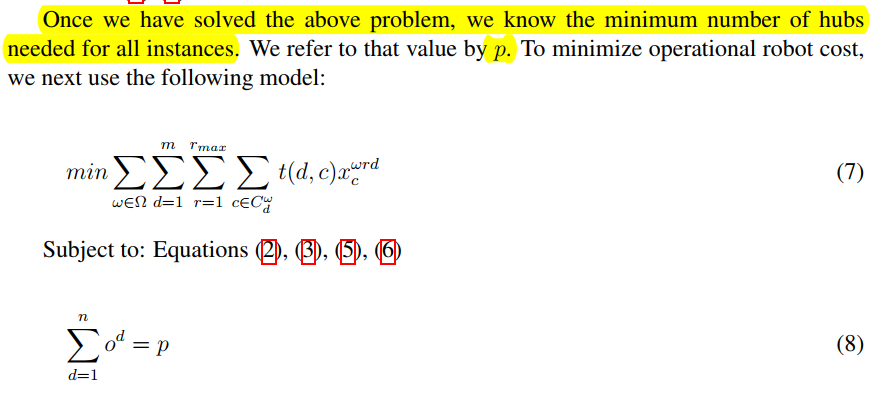